Imports

In [366]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from captum.attr import IntegratedGradients, DeepLift, FeatureAblation, FeaturePermutation


#device = torch.device("cpu")
#print(torch.cuda.is_available())
device = torch.device("cuda")

Some helper functions

In [367]:
def use_gpu(array):
    return torch.from_numpy(array).float().cuda()

def n_by_ps(total, ps):
    #return total percentages as numbers
    assert np.isclose(sum(ps), 1), 'ps should sum to 1'
    ns = np.floor(total * np.array(ps))
    ns[0] += total - sum(ns)
    return ns.astype(int).tolist()

def hist(x):
    pd.DataFrame(x).hist()
    
def subset_by_cancer(data, cancer='COAD', feature_subset=None):  
    assert cancer in ['COAD', 'STAD'], 'only COAD or STAD allowed for cancer'
    #re-order X for easier subsetting
    X = data['hist_counts'].T[:,list(range(0,14)) + list(range(21,27)) + list(range(14,21)) + list(range(27,40))]
    Y = data['targets']
    
    if feature_subset:
        assert feature_subset in ['COAD', 'STAD'], 'only COAD or STAD allowed for feature_subset'
        if cancer == 'COAD':
            return X[:,0:20], Y[0]
        else:
            return X[:,20:40], Y[1]
    else:
        if cancer == 'COAD':
            return X, Y[0]
        else:
            return X, Y[1]

Load prepared data. COAD is the study abbreviation for colon cancer, STAD for stomach cancer. I run this notebook in 6 ways: 
* cancer = 'COAD', feature_subset = None
* cancer = 'STAD', feature_subset = None
* cancer = 'COAD', feature_subset = 'COAD'
* cancer = 'STAD', feature_subset = 'COAD'
* cancer = 'COAD', feature_subset = 'STAD'
* cancer = 'STAD', feature_subset = 'STAD'

In [368]:
cancer = 'COAD'
feature_subset = 'COAD'

In [369]:
class geneticData(Dataset):
    def __init__(self, source):
        self.data = np.load(source, allow_pickle = True)
        self.x, self.y = subset_by_cancer(self.data, cancer = cancer, feature_subset = feature_subset)
        assert self.x.shape[0] == self.y.shape[0], 'sizes screwy'
        self.x_means = np.mean(self.x, axis=0)
        self.x_std=np.std(self.x, axis=0)

    def __getitem__(self, idx):
        return use_gpu(self.x[idx, :]), use_gpu(self.y[idx].reshape(-1))
    
    def __len__(self):
        return self.y.shape[0]


In [370]:
data_path = 'data_COAD_STAD_w1e6.npz'
full = geneticData(data_path)
train, test = random_split(full, n_by_ps(len(full), [.70, .30]))

n_features = full.x.shape[1]
batch_size=200
p = 0
print(n_features, " features, ", len(full), " bins")

20  features,  3119  bins


Note zero-inflation in mutation counts per bin. Here's some links with suggestions on how to handle it. Ex. transforming the target variable may be useful for training, then can un-transform at prediction time.   
https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/  
https://stats.stackexchange.com/questions/306630/network-architecture-to-predict-zero-inflated-output  
https://stats.stackexchange.com/questions/230765/regression-with-zero-inflated-continuous-response-variable-using-gradient-boosti  
https://stats.stackexchange.com/questions/157438/what-is-the-best-data-transformation-for-absolute-zero-inflated-distributions  
https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203  

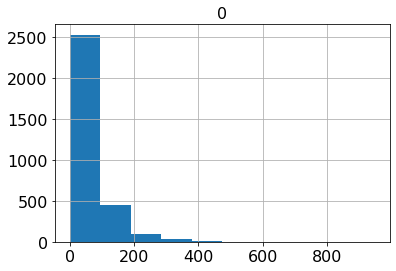

In [371]:
hist(full.y)

In [372]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle =True, num_workers = p)
#val_loader = DataLoader(val, batch_size=len(val), shuffle=False, num_workers = p)
test_loader = DataLoader(test, batch_size=len(test), shuffle=False, num_workers = p)

Define model

In [373]:
H1 = 50
H2 = 100
H3 = 50

model = nn.Sequential(
    torch.nn.BatchNorm1d(n_features), 
    nn.Linear(n_features, H1),
    nn.ReLU(),
    nn.Linear(H1, H2),
    nn.ReLU(),
    nn.Linear(H2, H2),
    nn.ReLU(),
    nn.Linear(H2, H2),
    nn.ReLU(),
    nn.Linear(H2, H2),
    nn.ReLU(),
    nn.Linear(H2, H2),
    nn.ReLU(),
    nn.Linear(H2, H3),
    nn.ReLU(),
    #nn.Dropout(p=0.2),
    nn.Linear(H3, 1),

).to(device)

opt = torch.optim.SGD(model.parameters(), lr=1e-2)#, momentum=0.8)
criterion = nn.L1Loss() 

In [374]:
torch.manual_seed(2515)
model.train()
epochs = 1000

for e in range(epochs): 
    epoch_loss = []
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss.append(loss)
    if e%50 ==0:
        print(f'epoch {e} loss: ', sum(epoch_loss))

epoch 0 loss:  tensor(624.5850, device='cuda:0', grad_fn=<AddBackward0>)
epoch 50 loss:  tensor(274.6187, device='cuda:0', grad_fn=<AddBackward0>)
epoch 100 loss:  tensor(245.4433, device='cuda:0', grad_fn=<AddBackward0>)
epoch 150 loss:  tensor(246.3278, device='cuda:0', grad_fn=<AddBackward0>)
epoch 200 loss:  tensor(236.9266, device='cuda:0', grad_fn=<AddBackward0>)
epoch 250 loss:  tensor(220.0110, device='cuda:0', grad_fn=<AddBackward0>)
epoch 300 loss:  tensor(231.8476, device='cuda:0', grad_fn=<AddBackward0>)
epoch 350 loss:  tensor(214.9232, device='cuda:0', grad_fn=<AddBackward0>)
epoch 400 loss:  tensor(191.0174, device='cuda:0', grad_fn=<AddBackward0>)
epoch 450 loss:  tensor(184.3818, device='cuda:0', grad_fn=<AddBackward0>)
epoch 500 loss:  tensor(190.9010, device='cuda:0', grad_fn=<AddBackward0>)
epoch 550 loss:  tensor(182.5233, device='cuda:0', grad_fn=<AddBackward0>)
epoch 600 loss:  tensor(172.8510, device='cuda:0', grad_fn=<AddBackward0>)
epoch 650 loss:  tensor(164.

Test time!  

Check test loss and prediction performance wrt variance explained. 

Not using a validation set here because almost all my hyperparameter tuning was done using training loss. 

In [375]:
model.eval()
for xb, yb in test_loader:
    pred = model(xb)
    print(criterion(pred, yb))

tensor(26.1181, device='cuda:0', grad_fn=<L1LossBackward>)


Expect the distribution of predictions and target values to be similar

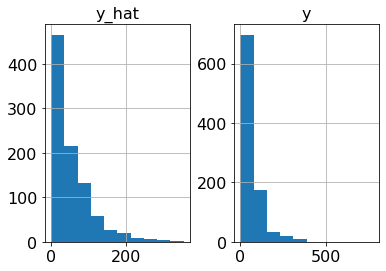

In [376]:
for X, y in test_loader:
    y_hat = model(X).cpu().detach().numpy().flatten()
    y = y.cpu().detach().numpy().flatten()
    res = pd.DataFrame.from_dict({'y_hat': y_hat, 'y': y})
    hist(res)

Scatter plot of predictions and target values.

Text(0, 0.5, 'y')

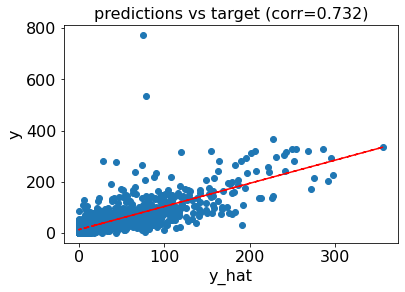

In [377]:
fig, ax = plt.subplots()
    
pf = np.polyfit(y_hat, y, 1)
p = np.poly1d(pf)
c = round(np.corrcoef(y_hat, y)[0,1], 3)

ax.plot(y_hat, y, 'o')
ax.plot(y_hat, p(y_hat),"r--")

ax.set_title(f'predictions vs target (corr={c})')
ax.set_xlabel('y_hat')
ax.set_ylabel('y')


Next, query features. 

In [378]:
X_train = train[:][0].detach().clone()
y_train = train[:][1].detach().clone()
X_test = test[:][0].detach().clone()

In [386]:
feature_names = ['E075-H3K4me1', 'E075-H3K4me3', 'E075-H3K9ac', 'E075-H3K9me3', 'E075-H3K27ac', 
                 'E075-H3K27me3', 'E075-H3K36me3', 'E076-H3K4me1', 'E076-H3K4me3', 'E076-H3K9ac', 
                 'E076-H3K9me3', 'E076-H3K27ac', 'E076-H3K27me3', 'E076-H3K36me3', 'E106-H3K4me1', 
                 'E106-H3K4me3', 'E106-H3K9me3', 'E106-H3K27ac', 'E106-H3K27me3', 'E106-H3K36me3', 
                 'E092-DNase', 'E092-H3K4me1', 'E092-H3K4me3', 'E092-H3K9me3', 'E092-H3K27ac', 
                 'E092-H3K27me3', 'E092-H3K36me3', 'E110-H3K4me1', 'E110-H3K4me3', 'E110-H3K9ac', 
                 'E110-H3K9me3', 'E110-H3K27me3', 'E110-H3K36me3', 'E111-H3K4me1', 'E111-H3K4me3', 
                 'E111-H3K9ac', 'E111-H3K9me3', 'E111-H3K27ac', 'E111-H3K27me3', 'E111-H3K36me3']

# subset as appropriate
feature_names = feature_names[0:20] if feature_subset == 'COAD' else feature_names
feature_names = feature_names[20:40] if feature_subset == 'STAD' else feature_names

corrcoefs = []
for i in range(X_train.shape[1]):
    corrcoefs.append(round(np.corrcoef(X_train.cpu().numpy()[:,i], y_train.cpu().numpy())[1,0], 3))

Text(-0.03, 0.5, 'number of mutations per bin')

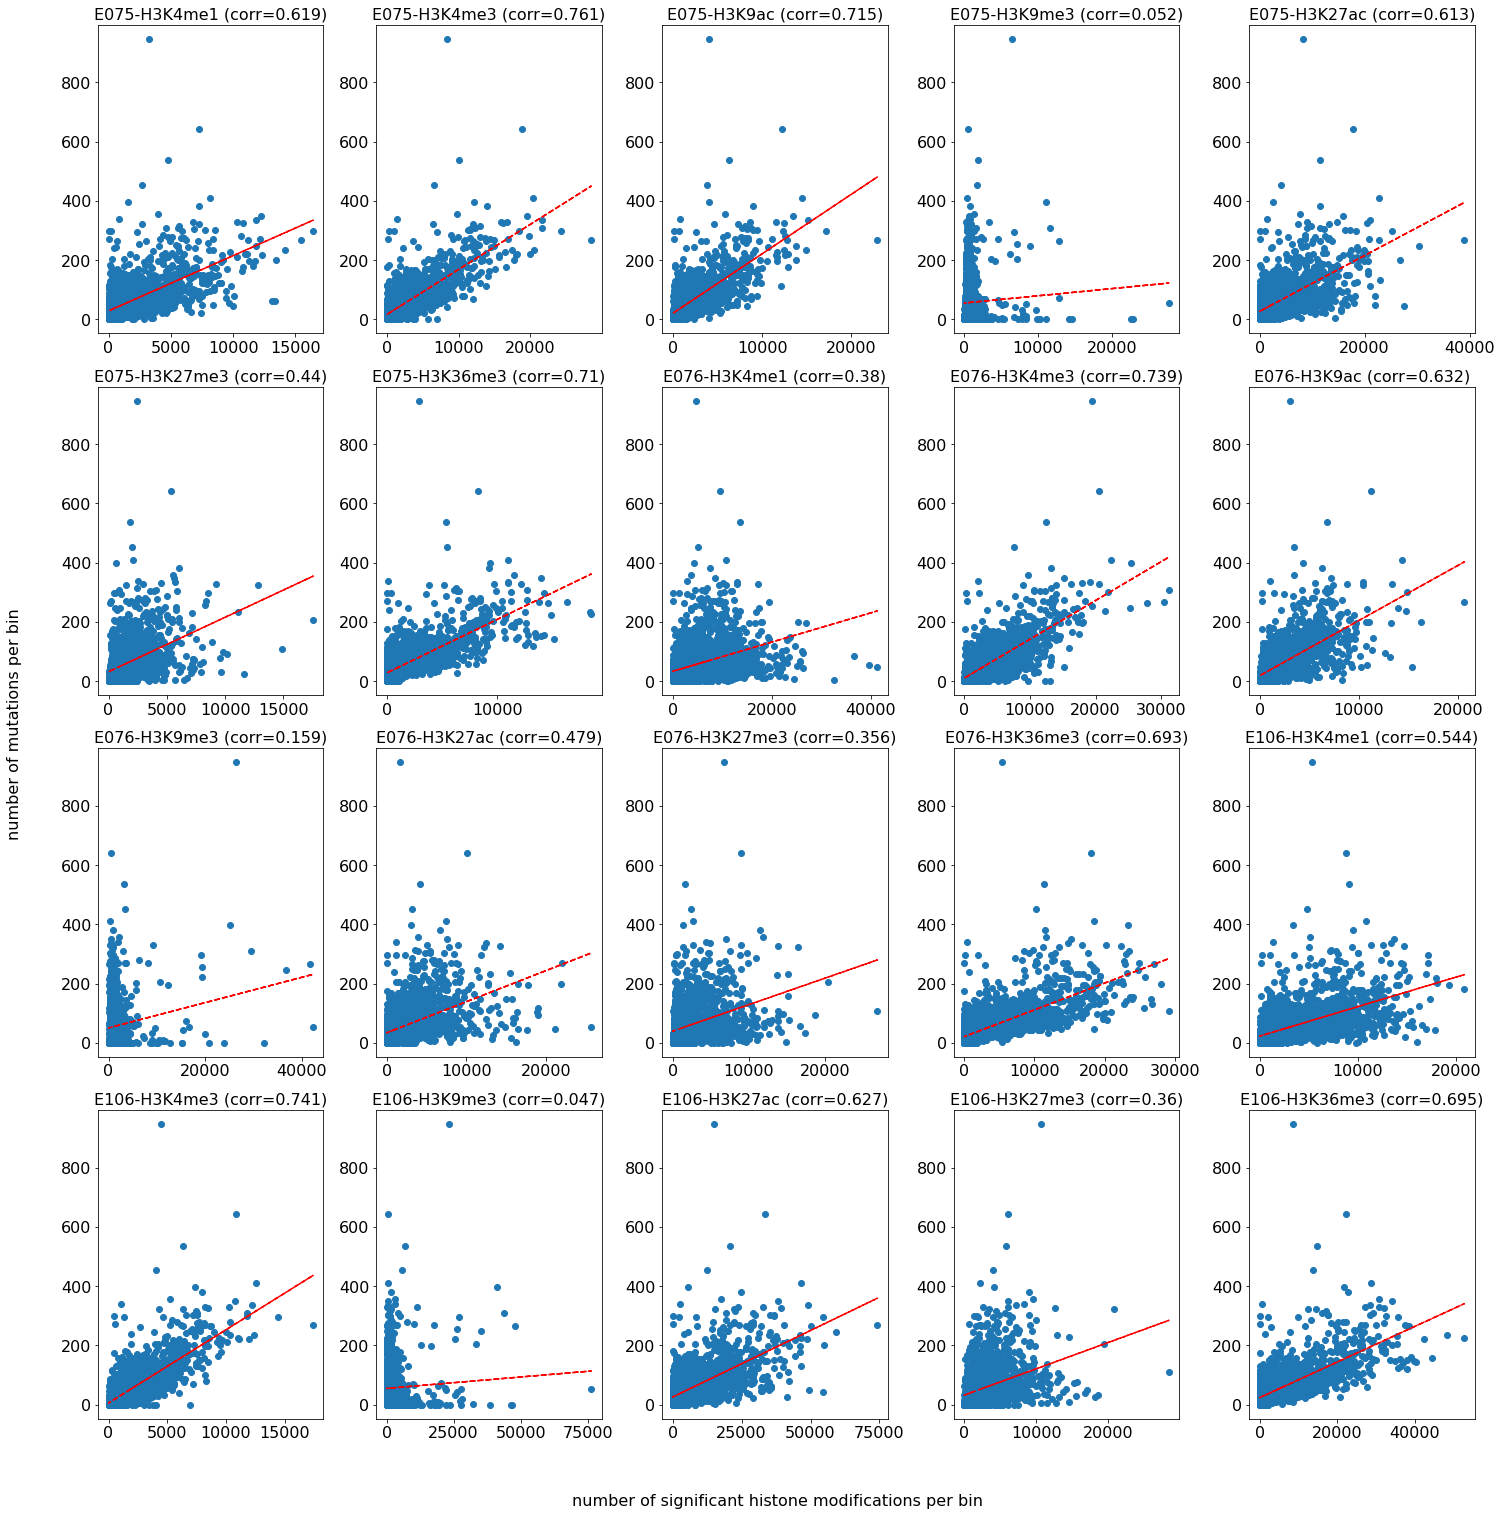

In [387]:
nrows = 8 if feature_subset == None else 4
fig, axs = plt.subplots(nrows=nrows, ncols=5, figsize=(20, 20), constrained_layout=True)
for i, (ax, col, corr) in enumerate(zip(axs.flat, feature_names, corrcoefs)):
    x = X_train.cpu().numpy()[:,i]
    pf = np.polyfit(x, y_train.cpu().numpy(), 1)
    p = np.poly1d(pf)

    ax.plot(x, y_train.cpu().numpy(), 'o')
    ax.plot(x, p(x),"r--")
    ax.set_title(col + ' (corr=' + str(corr) + ')')


fig.text(0.5, -0.04, 'number of significant histone modifications per bin', ha='center', va='center')
fig.text(-0.03, 0.5, 'number of mutations per bin', ha='center', va='center', rotation='vertical')

Next three cells modified from tutorial on feature importances https://captum.ai/tutorials/House_Prices_Regression_Interpret 

In [388]:
ig = IntegratedGradients(model)
dl = DeepLift(model)
fa = FeatureAblation(model)


ig_attr_test = ig.attribute(X_test, n_steps=50)
dl_attr_test = dl.attribute(X_test)
fa_attr_test = fa.attribute(X_test)

/home/cait/miniconda3/envs/csc2515/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/cait/miniconda3/envs/csc2515/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [389]:
# prepare attributions for visualization
    
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.cpu().detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.cpu().detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.cpu().detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)


width = 0.14
legends = ['IntGrads', 'DeepLift', 'Feature Permutation', 'Feature Ablation']


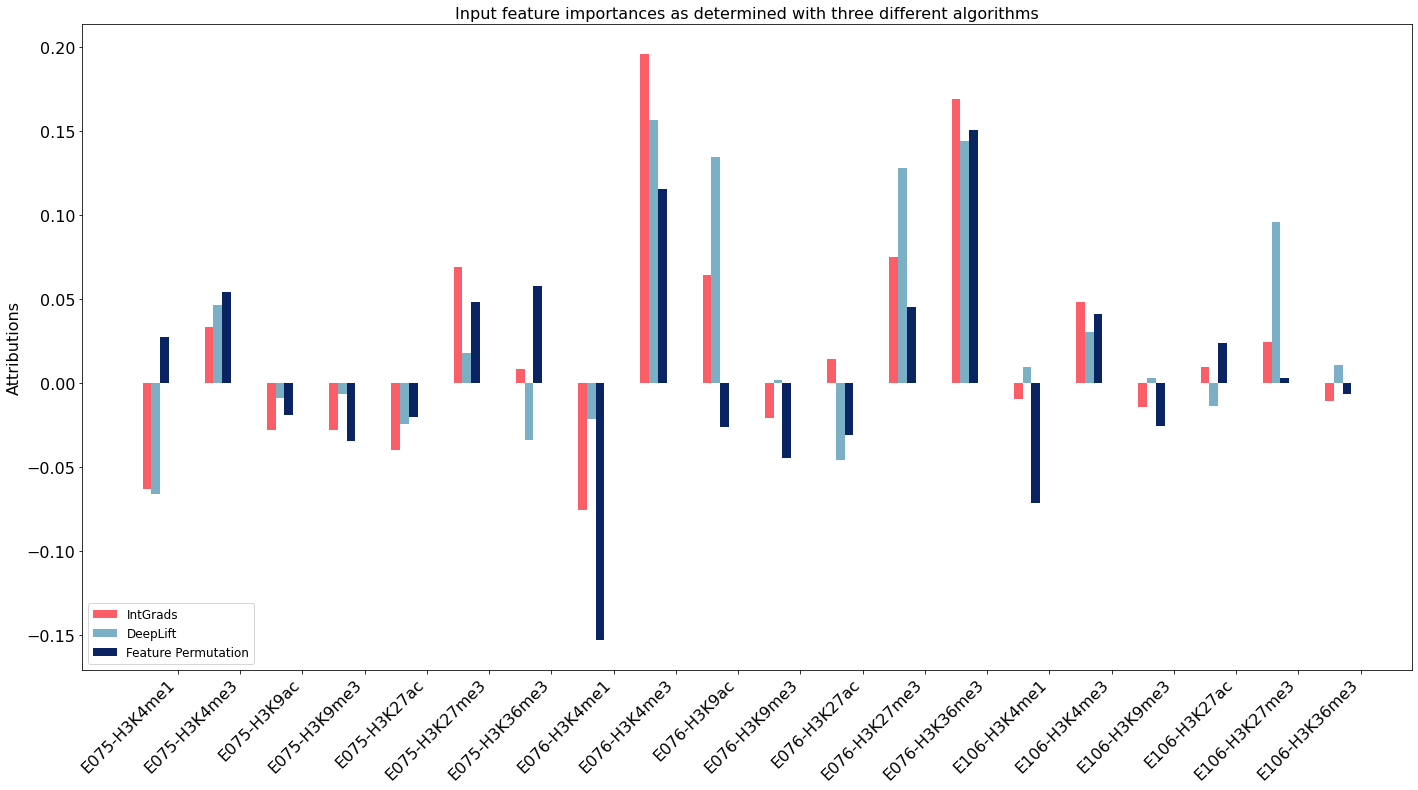

In [390]:
plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Input feature importances as determined with three different algorithms')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#FB3640')
ax.bar(x_axis_data + 1 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#247BA0')
ax.bar(x_axis_data + 2 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#0A2463')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

if feature_subset == None:
    for label in range(20,40):
        ax.get_xticklabels()[label].set_color("#333333")

plt.xticks(rotation=45, ha='right')
plt.legend(legends, loc=3)
plt.show()